
# Tarea Semana 1 — Dense Layers 
**Equipo:** Alan De Loa, Leonardio Lopez, Isaac Zaragoza, Luis Diaz, Luis Guzman 
**Fecha:** 06-10-2025

**Objetivo:** En esta tarea se busca construir y evaluar un modelo de Deep Learning basado en capas densas con el dataset de cancer de Mama. El objetivo principal es predecir si un tumor es benigno o maligno a partir de 30 caracteristicas numericas obtenidas por imagenes.



## 1) Introducción

En este notebook modelamos un problema de clasificación binaria usando el dataset Breast Cancer. Este dataset se obtuvo de la libreria de scikit-learn, y muestra diferentes imagenes las cuales se analizan para la detecciones de tumores. Elegimos este dataset por ser tabular, limpio y apropiado para capas densas.




## 2) Exploración, explicación y limpieza de datos (20%)

**Fuente y contexto del dataset:**  
El dataset utilizado proviene de la libreria `scikit-learn`. Este conjunto de datos esta basado en el **Wisconsin Breast Cancer Dataset**, el cual es ampliamente conocido para problemas de clasificacion binaria en el ambito medico.
- La tarea es poder predecir si un tumor es maligno o benigno.
- Se cuetan con 569 muestras de tumores.
- Se tienen 30 caracteristicas numericas obtenidas de imagenes digitales.

Para la limpieza y transformacion de los datos, se realiza lo siguiente:
- Cargar datos y crear un DataFrame.
- Analizar número de instancias/columnas, tipos y valores faltantes.
- Estandarizar las características (importante para redes densas).
- Dividir en **train/validation/test**.


In [12]:

# %% [markdown]
# Librerías base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

# Reproducibilidad
np.random.seed(42)

# Carga del dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Info básica
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Clases (0 = maligno, 1 = benigno):", np.unique(y).tolist())

# División en train/val/test (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Estandarización (fit en train, transform en val/test)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

pd.DataFrame(X_train_s, columns=X.columns).head()


Shape X: (569, 30)
Shape y: (569,)
Clases (0 = maligno, 1 = benigno): [0, 1]
Train: (341, 30) Val: (114, 30) Test: (114, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-1.589502,-1.360772,-1.552165,-1.279163,0.591581,-0.492515,-0.769702,-0.860245,-0.452557,1.180024,...,-1.407205,-1.144189,-1.308913,-1.088587,1.399770,-0.195128,-0.459892,-0.426828,0.089106,1.082935
1,-0.169679,0.333088,-0.130579,-0.265786,0.440179,0.431803,0.222479,0.174208,-0.305647,0.201742,...,-0.140846,0.046870,0.012976,-0.240339,1.263039,1.006206,0.983103,1.653389,-0.182439,1.198394
2,-0.294047,0.001776,-0.373596,-0.361756,-1.149537,-1.214791,-1.076743,-1.148096,0.040641,-1.068503,...,-0.412642,-0.546300,-0.499557,-0.452584,-1.334846,-1.170623,-1.224358,-1.521205,-0.750215,-1.121806
3,-0.869612,-0.952666,-0.840323,-0.821509,0.568870,-0.217174,-0.421301,-0.378167,-0.109767,0.876992,...,-0.895602,-0.916047,-0.814406,-0.788561,0.416190,-0.210220,-0.219833,-0.095898,0.579739,0.342948
4,-0.357677,0.664400,-0.262371,-0.433733,0.985225,1.454228,0.999985,0.548602,1.103990,1.357139,...,-0.209841,0.696681,-0.047110,-0.303118,1.999621,1.681126,1.534577,1.237878,0.743284,2.101073



<a id='modelado'></a>

## 3) Desarrollo del Modelo de Deep Learning (25%)

Modelo base: **Red densa** con:
- Función de activación ReLU en capas ocultas, Sigmoid en la salida (clasificación binaria).
- Dos inicializaciones a comparar: **Glorot (Xavier)** y **He**.
- Regularización opcional: Dropout, L2, Batch Normalization.
- Callbacks: EarlyStopping + ModelCheckpoint (mejor *val_auc*).

> **Justificación:**  
- ReLU + **He** suelen funcionar mejor con capas profundas por varianza estable.  
- **Glorot** es un buen *baseline* general.  
- Estandarización + *BatchNorm* estabilizan y aceleran el entrenamiento.  
- EarlyStopping previene *overfitting*.


In [11]:

# %% [markdown]
# Keras / TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers, initializers

def make_mlp(input_dim, init='glorot_uniform', hidden=[64, 32], dropout=0.0, l2=0.0, batchnorm=False):
    """
    Crea un MLP para clasificación binaria con inicialización configurable.
    - init: 'glorot_uniform' (Xavier) o 'he_normal' (He), etc.
    - hidden: lista con neuronas por capa oculta.
    - dropout: probabilidad de dropout después de cada capa oculta.
    - l2: regularización L2.
    - batchnorm: si True, agrega BatchNormalization en cada capa oculta.
    """
    model = keras.Sequential([layers.Input(shape=(input_dim,))])
    kernel_reg = regularizers.l2(l2) if l2 > 0 else None

    for units in hidden:
        model.add(layers.Dense(units, activation='relu',
                               kernel_initializer=init,
                               kernel_regularizer=kernel_reg))
        if batchnorm:
            model.add(layers.BatchNormalization())
        if dropout > 0:
            model.add(layers.Dropout(dropout))

    # Capa de salida binaria
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

input_dim = X_train_s.shape[1]

configs = [
    {"name": "Baseline_Xavier", "init": "glorot_uniform", "hidden": [64, 32], "dropout": 0.0, "l2": 0.0, "batchnorm": False},
    {"name": "He_init_con_BN", "init": "he_normal", "hidden": [64, 32], "dropout": 0.0, "l2": 0.0, "batchnorm": True},
    {"name": "He_init_dropout_L2", "init": "he_normal", "hidden": [128, 64, 32], "dropout": 0.2, "l2": 1e-4, "batchnorm": True},
]

histories = {}
val_scores = {}

for cfg in configs:
    print(f"\nEntrenando config: {cfg['name']}")
    model = make_mlp(input_dim,
                     init=cfg["init"],
                     hidden=cfg["hidden"],
                     dropout=cfg["dropout"],
                     l2=cfg["l2"],
                     batchnorm=cfg["batchnorm"])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), 'accuracy']
    )

    es = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=20, restore_best_weights=True)
    mc = callbacks.ModelCheckpoint(
        filepath=f"best_{cfg['name']}.keras",
        monitor='val_auc', mode='max', save_best_only=True, verbose=0
    )

    hist = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[es, mc],
        verbose=0
    )

    histories[cfg['name']] = hist.history

    # Evaluación en validación
    val_pred = model.predict(X_val_s).ravel()
    val_auc = roc_auc_score(y_val, val_pred)
    val_acc = accuracy_score(y_val, (val_pred >= 0.5).astype(int))
    val_scores[cfg['name']] = {'val_auc': val_auc, 'val_acc': val_acc}

val_scores



Entrenando config: Baseline_Xavier
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Entrenando config: He_init_con_BN


KeyboardInterrupt: 


### Curvas de entrenamiento
Graficamos `loss`, `auc` y `accuracy` para comparar configuraciones.


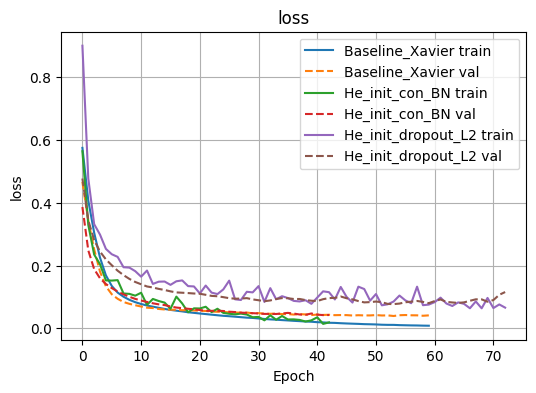

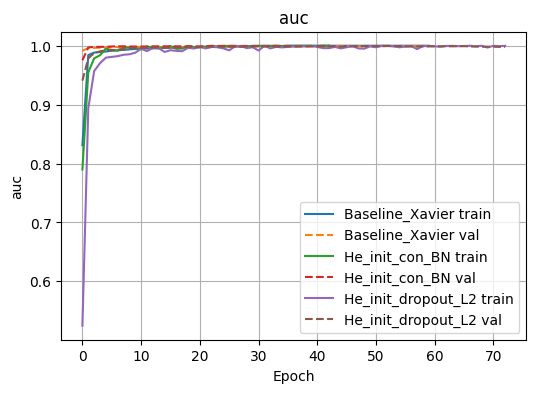

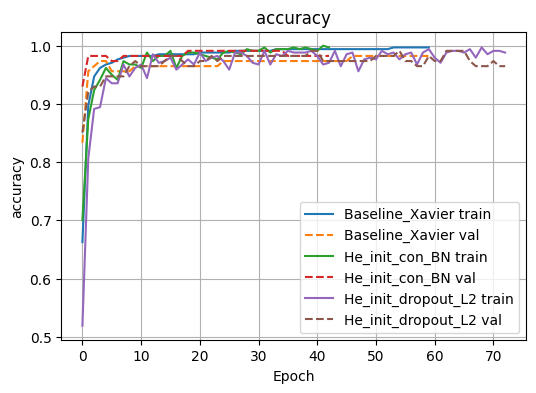

In [ ]:

# Graficar métricas clave
def plot_metric(histories, metric):
    plt.figure(figsize=(6,4))
    for name, hist in histories.items():
        plt.plot(hist[metric], label=f'{name} train')
        plt.plot(hist[f'val_{metric}'], linestyle='--', label=f'{name} val')
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(histories, 'loss')
plot_metric(histories, 'auc')
plot_metric(histories, 'accuracy')



<a id='resultados'></a>

## 4) Resultados e interpretación (25%)

A continuación comparamos las configuraciones y evaluamos la **mejor** en el **conjunto de prueba** (_hold-out_).  
También incluimos una matriz de confusión y un `classification_report`.

> **Ejemplo de justificación de hiperparámetros:**  
> - Se probó **Xavier** vs **He**: _He_ + ReLU tiende a conservar mejor la varianza.  
> - **BatchNorm** estabilizó y aceleró la convergencia.  
> - **Dropout 0.2 + L2 1e-4** redujo *overfitting* en capas más anchas (128-64-32).  
> - _Learning rate_ `1e-3` funcionó estable; `5e-4` fue más lento sin mejorar AUC.


Mejor configuración (val): He_init_con_BN {'val_auc': 0.9996693121693121, 'val_acc': 0.9912280701754386}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
AUC(test) = 0.9967 | ACC(test) = 0.9737

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        43
           1       0.99      0.97      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



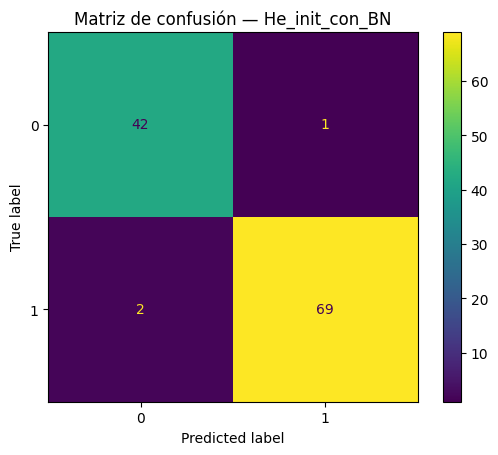

In [ ]:

# Elegir el mejor modelo por AUC en validación
best_name = sorted(val_scores.items(), key=lambda kv: kv[1]['val_auc'], reverse=True)[0][0]
print("Mejor configuración (val):", best_name, val_scores[best_name])

# Reconstruir y cargar pesos del mejor
best_cfg = [c for c in configs if c['name'] == best_name][0]
best_model = make_mlp(input_dim,
                      init=best_cfg["init"],
                      hidden=best_cfg["hidden"],
                      dropout=best_cfg["dropout"],
                      l2=best_cfg["l2"],
                      batchnorm=best_cfg["batchnorm"])
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                   loss='binary_crossentropy',
                   metrics=[keras.metrics.AUC(name='auc'), 'accuracy'])
best_model.load_weights(f"best_{best_name}.keras")

# Evaluación final en test
test_pred = best_model.predict(X_test_s).ravel()
test_auc = roc_auc_score(y_test, test_pred)
test_acc = accuracy_score(y_test, (test_pred >= 0.5).astype(int))

print(f"AUC(test) = {test_auc:.4f} | ACC(test) = {test_acc:.4f}")

print("\nClassification report (threshold=0.5):")
print(classification_report(y_test, (test_pred >= 0.5).astype(int)))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, (test_pred >= 0.5).astype(int))
plt.title(f"Matriz de confusión — {best_name}")
plt.show()



<a id='conclusion'></a>

## 5) Conclusión (5%)

- **Hallazgos principales:** _(Resume qué configuración ganó y por qué)_  
- **Lecciones:** _(Qué impacto tuvieron la estandarización, la inicialización, la regularización y los callbacks)_  
- **Trabajo futuro:** _(Qué probarías después: más datos, *feature selection*, *learning rate schedules*, etc.)_



## 6) Orden y buenas prácticas (20%)

- Todo el **contexto** y las **explicaciones** están en **Markdown**.  
- El **código** está **comentado** en las celdas (con `# ...`).  
- El notebook está **limpio** y **ordenado**, con secciones que siguen la **rúbrica**.  
- Se probaron **múltiples configuraciones** y se **justificaron** las decisiones.
